**<h1 align="center">Universidad Internacional del Ecuador</h1>**

**<h2 align="center">Procesamiento de Imágenes y Señales</h2>**

***<h3 align="left">Grupo 6</h3>***
- ***<h3 align="left">Dario Wladimir Herrera Chávez</h3>***
- ***<h3 align="left">Jonathan Fabricio Gualli Ramirez</h3>***
- ***<h3 align="left">Jorge Armando Quizamanchuro Fuel</h3>***

> **Nota**
>
> Ejecuta el notebook en orden secuencial para que las funciones declaradas en el primer bloque puedan ser usadas en las otras secciones.

## Objetivos

* Aplicar y comparar técnicas de preprocesamiento para la correcta segmentación de imágenes infrarrojas (IR), partiendo del análisis teórico revisado en la signatura.

* Se busca demostrar que una segmentación directa, sin etapas previas de mejora y delimitación, puede producir resultados poco precisos.

* Se propone identificar y seleccionar el área de interés (ROI) de las imágenes IR mediante la aplicación de filtros, técnicas de detección de bordes y operaciones de morfología matemática.

* Se realizará una comparación de al menos dos enfoques, evaluándolos tanto de manera independiente como secuencial, con el fin de determinar cuál ofrece una mejor delimitación del área relevante.

* Finalmente, el área de interés obtenida será utilizada como máscara para aplicarse sobre el conjunto de prueba (test set), de modo que únicamente se visualice la región segmentada, mientras que el resto de los píxeles de la imagen sean asignados con valor cero, validando así la efectividad del proceso de segmentación.

## Desarrollo

- En primera instancia, se desarrolla un módulo utilitario de funciones que servirá como soporte a lo largo de todo el proyecto. Este módulo centraliza procesos repetitivos y facilita la reutilización de código, permitiendo una implementación más organizada.

In [49]:
import os
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split

matplot_style: str = "default"
all_images_path: str = "resources/dataset/soldadura/all"
test_images_path: str = "resources/dataset/soldadura/test"
train_images_path: str = "resources/dataset/soldadura/train"
target_image_path: str = "resources/dataset/soldadura/all/1734589460685.tif"
train_size_value: float = 0.8
randon_state_value: int = 42
black: int = 0
white: int = 255
roi_matrix_shape = (7,7)
border_matrix_shape = (5,5)

def get_area_by_mask(mask):
    return np.sum(mask == 255)

def mask_apply(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

def kmeans_with_roi_image(image, mask, n_clusters = 5):
    roi_pixels = image[mask == 255]

    if len(roi_pixels) < n_clusters:
        print("Reducing the number of clusters automatically.")
        n_clusters = max(1, len(roi_pixels))

    roi_pixels = np.float32(roi_pixels.reshape(-1,1))
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.2
    )
    _, labels, centers = cv2.kmeans(
        roi_pixels,
        n_clusters,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    centers = centers.flatten()
    labels = labels.flatten()
    segmented = np.zeros_like(image)
    segmented[mask == 255] = centers[labels]
    return segmented, centers

def set_matplot_style(style: str) -> None:
    plt.style.use(style)
    return None

def copy_images(split_images: List[str], root_path: str, destination_path: str) -> None:
    for file in split_images:
        shutil.copy2(os.path.join(root_path, file), os.path.join(destination_path, file))
    return None

def split_images_in_groups(test_path: str, train_path: str, train_size: float, random_state: int) -> None:
    os.makedirs(test_path, exist_ok=True)
    os.makedirs(train_path, exist_ok=True)

    all_images = os.listdir(all_images_path)
    tr_images, te_images = train_test_split(all_images, train_size = train_size, random_state = random_state)
    copy_images(tr_images, all_images_path, test_images_path)
    copy_images(te_images, all_images_path, train_images_path)

    print("################################################")
    print("                   Summary                      ")
    print("################################################")
    print(f"> Number of Images: {len(all_images)}")
    print(f"> Number of Train Images copied: {len(tr_images)}")
    print(f"> Number of Test Images copied: {len(te_images)}")
    print("################################################")
    return None

def show_summary(msk1, msk2, msk3) -> None:
    print("##################################################################################")
    print("                                     Summary                                      ")
    print("##################################################################################")
    print(f"> Area with prepare_and_get_roi_on_image method: {get_area_by_mask(msk1)}")
    print(f"> Area with prepare_and_get_roi_on_image_with_border method: {get_area_by_mask(msk2)}")
    print(f"> Area with prepare_and_get_roi_on_image_with_watershed method: {get_area_by_mask(msk3)}")
    print("#################################################################################")
    return None

def plot_roi_result(trg_image, custom_mask, segmented_type) -> None:
    target_roi_image = mask_apply(trg_image, custom_mask)

    custom_segmented_roi, centers = kmeans_with_roi_image(target_roi_image, custom_mask, 5)
    print("Centroides:", centers.flatten())

    set_matplot_style(matplot_style)
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(trg_image, cmap='gray')
    plt.title("Imágen Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(target_roi_image, cmap='gray')
    plt.title(f"ROI segmentada | {segmented_type}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(custom_segmented_roi, cmap='jet')
    plt.title(f"KMeans ROI segmentada | {segmented_type}")
    plt.axis('off')
    return None

* Como etapa inicial del procesamiento, se procede a dividir el conjunto de datos, conformado por fotografías del proceso de soldadura, en subconjuntos de entrenamiento (train) y prueba (test). Esta separación permite estructurar adecuadamente la información para el desarrollo, validación y evaluación de los modelos y técnicas que serán aplicados en etapas posteriores del procesamiento y análisis de imágenes.

In [50]:
set_matplot_style(matplot_style)
split_images_in_groups(test_images_path, train_images_path, train_size_value, randon_state_value)

################################################
                   Summary                      
################################################
> Number of Images: 348
> Number of Train Images copied: 278
> Number of Test Images copied: 70
################################################


* Una vez con nuestro dataset divido, procedemos a crear nuestros métodos para poder preparar las imágenes.

> Los métodos presentados a continuación reciben una imagen como entrada, la cual es sometida a una serie de etapas de preprocesamiento que incluyen filtrado, umbralización y operaciones de morfología matemática. El objetivo de estos procesos es mejorar la calidad de la imagen original, reducir el ruido y resaltar las características relevantes, permitiendo así identificar y delimitar de manera más precisa el área de interés (ROI).

- #### *prepare_and_get_roi_on_image (M1)*

In [51]:
def prepare_and_get_roi_on_image(image):
    # Filtro Gausiano permite reducir el ruido térmico sin afecta demasiado la estructura.
    # Defino un size de 7x7 para poder operar de mejora manera en una región más amplia.
    blur_image = cv2.GaussianBlur(image, roi_matrix_shape, 0)

    # Realizo una umbralización para transformar la imágen en binaria (0 - 255).
    # Fusiono a los métodos THRESH_BINARY + THRESH_OTSU, esto permite dividir la imágen en fondo y objeto buscando el mejor umbral.
    _, image_threshed = cv2.threshold(
        blur_image, black, white,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Defino mi kernel para realizar las operacion de apertura y cierre sobre el vecindario.
    kernel = np.ones(roi_matrix_shape, np.uint8)

    # Realizo un proceso de apertura (Erosión seguida de Dilatación) sobre la imagen umbralizada, permite eliminar el ruido pequeño
    opening = cv2.morphologyEx(image_threshed, cv2.MORPH_OPEN, kernel)
    # Realizo un proceso de cierre (Dilatación seguida de Erosión) sobre la imagen umbralizada, permite rellenar huecos.
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Analizamos la imágen binaria para detectar las regiones blancas conectada, permite asignar una etiqueta distinta a cada region
    binary_image_num_labels, binary_image_labels, stats, _ = cv2.connectedComponentsWithStats(closing)

    # Definimos el área de interés Roi
    if binary_image_num_labels > 1:
        # Existe un objeto blanco en la imágen, área de interés, en este caso soldadura, asigno el objeto más grande
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

        # Creo una máscara, totalmente negra.
        mask = np.zeros_like(image)

        # La máscara inicial totalmente negra se llenará de blanco si se cumple la condición
        mask[binary_image_labels == largest_label] = white
    else:
        mask = closing

    return mask

- #### *prepare_and_get_roi_on_image_with_border (M2)*

In [52]:
def prepare_and_get_roi_on_image_with_border(image):
    # Filtro Gausiano permite reducir el ruido térmico sin afecta demasiado la estructura.
    # Defino un size de 5x5 para poder operar de mejora manera en una región más pequeña a diferencia de la anterior.
    blur_image = cv2.GaussianBlur(image, border_matrix_shape, 0)

    # Realizo una umbralización para transformar la imágen en binaria (0 - 255).
    # Con la obtención del gradiente clasifico los umbrales altos y bajos en este caso se determina si es un borde fuerte o débil
    edges = cv2.Canny(blur_image, 5, 50)

    # Defino mi kernel para realizar las operacion de dilatación y cierre sobre el vecindario.
    kernel = np.ones(border_matrix_shape, np.uint8)

    # Permite unir segmentos cercanos, facilitando cerrar la figura.
    dilated = cv2.dilate(edges, kernel, iterations=2)

    # Realizo un proceso de cierre (Dilatación seguida de Erosión) sobre la imagen.
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

    # Permite buscar regiones blancas cerradas.
    binary_image_contours, _ = cv2.findContours(
        closed,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # Creo una máscara inicial con fondo totalmente negro
    mask = np.zeros_like(image)

    # Selecciono el contorno mayor
    if len(binary_image_contours) > 0:
        largest = max(binary_image_contours, key=cv2.contourArea)
        # Defino el área de interés ROI
        cv2.drawContours(mask, [largest], -1, 255, -1)

    return mask

- #### *prepare_and_get_roi_on_image_with_watershed (M3)*

In [53]:
def prepare_and_get_roi_on_image_with_watershed(image):
    # Filtro Gausiano permite reducir el ruido térmico sin afecta demasiado la estructura.
    # Defino un size de 5x5 para poder operar de mejora manera en una región más pequeña a diferencia de la anterior.
    blur_image = cv2.GaussianBlur(image, roi_matrix_shape, 0)

    # Realizo una umbralización para transformar la imágen en binaria (0 - 255).
    # Fusiono a los métodos THRESH_BINARY + THRESH_OTSU, esto permite dividir la imágen en fondo y objeto buscando el mejor umbral.
    _, image_threshed = cv2.threshold(
        blur_image, black, white,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Elimino ruido pequeño
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(image_threshed, cv2.MORPH_OPEN, kernel, iterations=2)

    # Determinó fondo seguro
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Transformada de distancia (encuentra centros)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    # Obtengo región segura del objeto
    _, sure_fg = cv2.threshold(
        dist_transform,
        0.5 * dist_transform.max(),
        255, 0
    )

    sure_fg = np.uint8(sure_fg)

    # Región desconocida
    unknown_region = cv2.subtract(sure_bg, sure_fg)

    # Etiquetado de marcadores
    num_labels, markers = cv2.connectedComponents(sure_fg)

    markers = markers + 1
    markers[unknown_region == 255] = 0

    # Aplicación de watershed
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)

    # Máscara final
    mask = np.zeros_like(image)
    mask[markers > 1] = 255

    return mask

* Con los métodos establecidos, se pueden identificar la siguiente diferencias:

<center>

|                M1                 |              M2               |                M3                |
|:---------------------------------:|:-----------------------------:|:--------------------------------:|
|      Segmenta por intensidad      |      Segmenta por forma       |      Segmenta por regiones       |
|         Usa umbral (Otsu)         |         Usa gradiente         |          Usa marcadores          |
|      Usa componentes conexos      |         Usa contornos         |  Usa transformada de distancia   |
|         Basado en brillo          |      Basado en frontera       |       Basado en topología        |
|        Separa fondo-objeto        |   Detecta discontinuidades    |  Separa regiones por inundación  |
| Robusto ante transiciones suaves  | Sensible a gradientes débiles | Robusto ante regiones adyacentes |

</center>

* Analizadas las fortalezas y debilidades de cada función de segmentación, se procede a ejecutar cada una de ellas con el objetivo de evaluar su desempeño práctico y comparar visual y cuantitativamente los resultados obtenidos.

> [!NOTE]
> <br>
> Por motivos académicos únicamente se seleccionará una sola imagen del grupo del dataset para evaluar y presentar de mejor manera los resultados.

In [54]:
target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

mask_method_with_threshold = prepare_and_get_roi_on_image(target_image)
mask_method_with_gradient = prepare_and_get_roi_on_image_with_border(target_image)
mask_method_with_markers = prepare_and_get_roi_on_image_with_watershed(target_image)

show_summary(mask_method_with_threshold, mask_method_with_gradient, mask_method_with_markers)

##################################################################################
                                     Summary                                      
##################################################################################
> Area with prepare_and_get_roi_on_image method: 6069
> Area with prepare_and_get_roi_on_image_with_border method: 3175
> Area with prepare_and_get_roi_on_image_with_watershed method: 4834
#################################################################################


#### *Análisis cuantitativo*

- A partir del análisis comparativo del área segmentada por cada método, se concluye que el método basado en umbralización presenta el mejor desempeño en la delimitación de la zona de interés, logrando una segmentación más completa y consistente.

- El método basado en gradientes muestra un rendimiento inferior, evidenciando una sub-segmentación significativa debido a la naturaleza suave de las transiciones térmicas en la imagen.

- Por su parte, el método basado en marcadores (watershed) ofrece un resultado intermedio, proporcionando una segmentación más controlada y estructuralmente coherente, aunque ligeramente más conservadora que la obtenida mediante umbralización.

Ahora procedemos a corroborar de manera gráfica los resultados del área de interés

- #### *Máscara segmentada por intensidad (M1)*

Centroides: [ 94.945595  90.38746  137.63829  100.27452  108.17453 ]


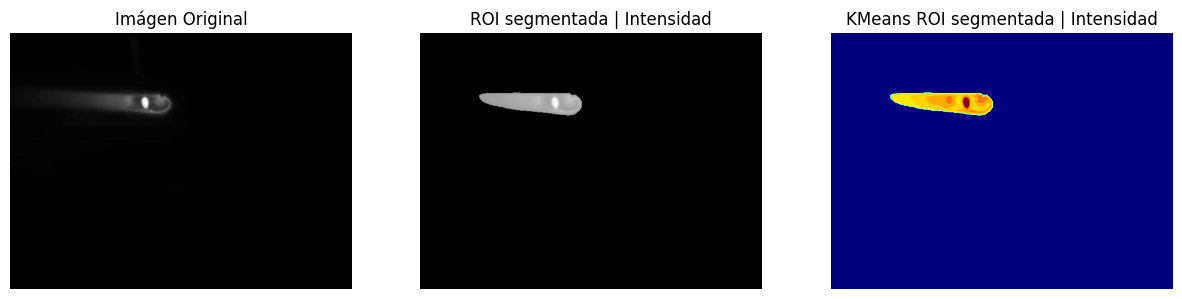

In [60]:
plot_roi_result(target_image, mask_method_with_threshold, "Intensidad")

- #### *Máscara segmentada por forma (M2)*

Centroides: [112.417175  94.862465 102.246216 138.31285   86.979744]


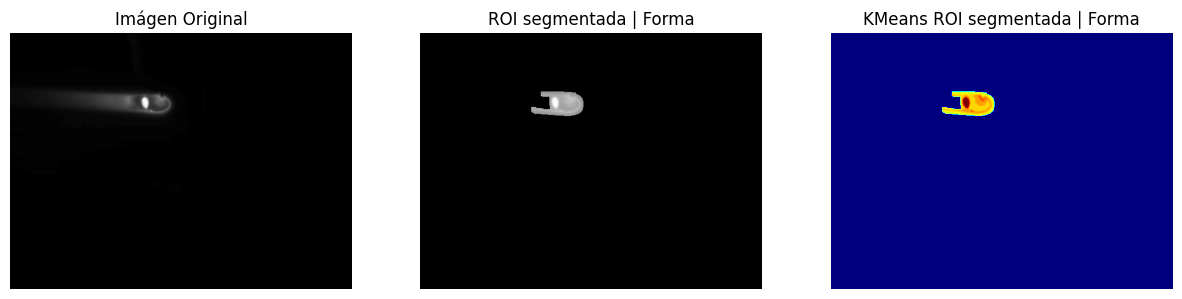

In [59]:
plot_roi_result(target_image, mask_method_with_gradient, "Forma")

- #### *Máscara segmentada por región (M3)*

Centroides: [139.37424  98.10517  92.82655 119.92857 104.86325]


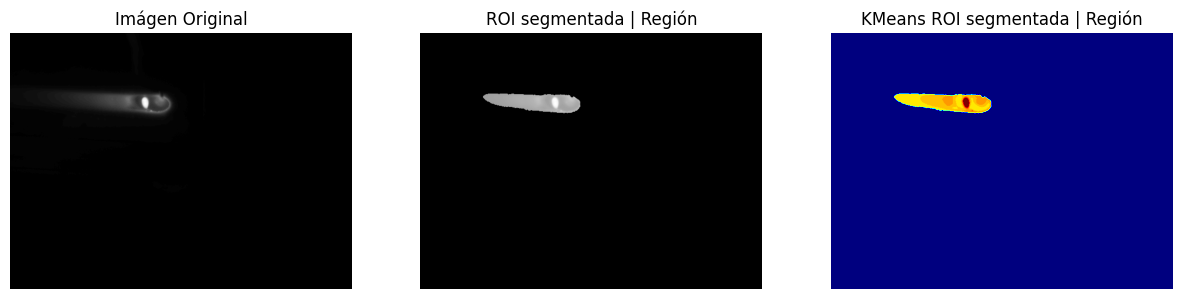

In [58]:
plot_roi_result(target_image, mask_method_with_markers, "Región")

### Análisis cualitativo

- Al comparar los resultados tanto cuantitativos como cualitativos, se puede concluir que el método basado en umbralización es el que mejor delimita la zona de interés. En las imágenes se observa que este método logra capturar de forma más completa y continua la región de la soldadura, sin dejar partes importantes fuera y manteniendo una forma coherente.

- Por otro lado, el método basado en gradientes presenta varias limitaciones. Visualmente se nota que solo detecta las zonas donde hay cambios más fuertes de intensidad, lo que hace que la región real quede incompleta. Esto ocurre porque en las imágenes térmicas los cambios de temperatura son suaves y progresivos, por lo que no existen bordes bien definidos que el método pueda detectar fácilmente.

- En cuanto al método basado en marcadores (watershed), los resultados muestran una segmentación más organizada y estructurada. Sin embargo, es un poco más conservador que el método de umbralización, ya que deja fuera pequeñas zonas que sí son consideradas parte del área de interés en el primer método. Aun así, se mantiene como una opción bastante sólida y equilibrada.

## Conclusiones

La implementación de una Región de Interés (ROI) demuestra ser un paso fundamental dentro del proceso de análisis.

Al restringir el procesamiento únicamente a la zona relevante:

- Se reduce significativamente la cantidad de píxeles a analizar.

- Se minimiza la influencia del ruido o del fondo.

- Se mejora la precisión de cálculos posteriores (como medición de área o temperatura).

- Se incrementa la eficiencia computacional.

El uso de una ROI no solo optimiza el rendimiento del algoritmo, sino que también mejora la confiabilidad de los resultados obtenidos, al concentrar el análisis exclusivamente en la región de interés proporcionada.